In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [716]:
import covdict
import json
import numpy as np
import os
import pandas as pd
import scipy.stats as st
import time
from IPython.html import widgets
from helper.plots import smoothfit, tuning
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import scale

## Helper functions for loading and processing data (from Nick Sofroniew)

In [3]:
def align(table, primary, index):
    table['sourceId'] = primary['sourceId']
    table.set_index(index, inplace = True)
    table.columns = table.columns.astype('float')
    return table

In [8]:
def load(session):
    
    with open(os.path.join(path, session, 'info.json')) as infile:
        info = json.load(infile)
        
    d = {}

    # Load the units, whih have our primary keys
    d['units'] = pd.DataFrame.from_csv(os.path.join(path, session, 'tables', 'units.csv'))
    
    # Load tables   
    d['tuning'] = pd.DataFrame.from_csv(os.path.join(path, session, 'tables', 'tuning.csv'))   
    d['tuning'] = align(d['tuning'], d['units'], ['sourceId', 'label'])
    d['tuningNum'] = d['tuning'].xs('numTrials', level='label')
    err = d['tuning'].xs('stdRate', level='label').divide(d['tuningNum'].apply(np.sqrt))
    d['tuning'] = d['tuning'].xs('meanRate', level='label')
    d['tuningErr'] = err
    d['tuningSummary'] = summarize(d['tuning'])
  
    d['units'].set_index('sourceId',inplace = True)

    # Add tables
    d = pd.concat([d[x] for x in d.keys()], axis = 1, keys = d.keys())
    
    info['contributors'] = ', '.join(info['contributors'])
    info['dimensions'] = str(info['dimensions'])
    info['session'] = session
    info = pd.DataFrame(info, index = [str(info['id'])])
    
    return d, info

In [6]:
smooth = 1

def summarize(df):
    x = df.columns.values
    xs, ys = smoothfit(x, df.values[0], smooth=smooth)
    smoothed = [smoothfit(x, y, smooth=smooth)[1] for y in df.values]

    summary = pd.DataFrame(index=df.index)
    summary['Baseline'] = [y[-1] for y in smoothed]
    summary['Max'] = [max(y) for y in smoothed]
    summary['ArgMax'] = [xs[np.argmax(y)] for y in smoothed]
    summary['Min'] = [min(y) for y in smoothed]
    summary['Mean'] = [np.mean(y) for y in smoothed]

    summary['Activation'] = summary.Max - summary.Baseline
    summary['Supression'] = summary.Baseline - summary.Min
    summary['Range'] = summary.Max - summary.Min
    summary['Modulation'] = (summary.Activation - summary.Supression)/(summary.Activation + summary.Supression)
    summary['TotalModulation'] = (summary.Max - summary.Min)/(summary.Max + summary.Min)
    
    return summary

## Load data and summarize info

In [471]:
path = '/Users/fannjiangc/data/paper.tuning/'
session = 13 # animal ID

data = load('%02g' % session)
table = data[0]
info = data[1]
hz = info['rate-hz'][0] # sampling frequency

#### Metadata

In [161]:
info

,animal,animal-state,contributors,date,depth-microns,dimensions,experiment,id,indicator,lab,location,method,pixels-per-micron,rate-hz,region,session
Anm_0216166,Mouse,Awake head-fixed,Nicholas Sofroniew,2013_07_17,200,"[512, 512, 0]",Tactile Virtual Reality,Anm_0216166,GCaMP6s,Svoboda Lab,Janelia Research Campus,Two-photon raster,1.15,7.1,vS1,13


In [162]:
units = table.units.reset_index()
n_units = units.count()['sourceId'] # number of total neurons

## Identify tuned and active neurons

#### Fractions of tuned and active neurons

In [523]:
tuned = units.pVal < 0.05
active = units.unitMean > np.percentile(units.unitMean, 80)
n = sum(active) # number of active neurons
summary = pd.DataFrame([sum((~active) & (~tuned)), sum(tuned), sum(active & (~tuned))], 
                               index=['inactive','tuned','untuned'], columns=['number'])
summary['frac'] = 100 * summary.number / summary.number.sum()
print summary

          number       frac
inactive     166  45.479452
tuned        163  44.657534
untuned       36   9.863014


#### Keep only significantly tuned neurons

In [492]:
with open(os.path.join(path, str(session), 'params', 'covariates.json')) as infile:
    covariates = json.load(infile)
covariates = pd.DataFrame([x['value'] for x in covariates], index=[str(x['name']) for x in covariates]).T

In [493]:
timeseries = pd.DataFrame.from_csv(os.path.join(path, str(session), 'sources', 'timeseries.csv'))

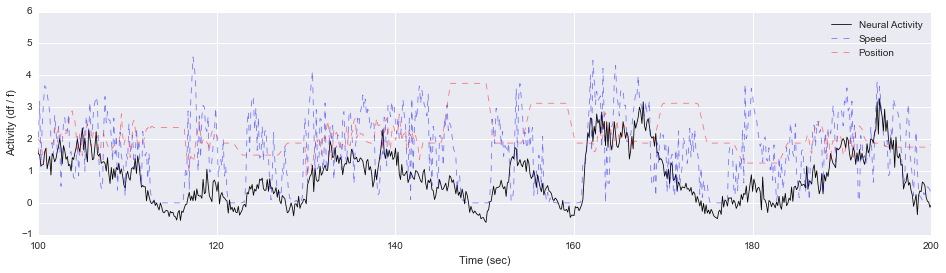

In [593]:
ts = timeseries.loc[active, :].values
n_samp = ts.shape[1] # number of samples

start = 100
stop = 200

def disp(s):
    sns.set_style('darkgrid');
    plt.figure(figsize=(16, 4));
    x = np.arange(n_samp) / hz
    plt.plot(x, ts[s, :], c='k', linewidth=0.8);
    plt.xlabel('Time (sec)');
    plt.ylabel('Activity (df / f)');
    
    plt.plot(x, covariates.speed / 16, '--b', alpha=0.5, linewidth=0.8);
    plt.plot(x, covariates.corPos / 8, '--r', alpha=0.5, linewidth=0.8);
    plt.xlim(start, stop);
    plt.ylim(-1, 6);
    plt.legend(['Neural Activity', 'Speed', 'Position']);
    
widgets.interact(disp, s = (0, n - 1, 1));

In [703]:
win = np.max([n + 1, 2 * hz])
shift = 0.2

# Sample covariance per time window
X = np.vstack([np.cov(ts[:, i : i + win])[np.triu_indices(n)] for i in np.arange(0, n_samp - win, shift * win)]).T
n_win = X.shape[1]

In [704]:
reg_names = ['xSpeed', 'ySpeed', 'corPos']
reg_idx = [np.where(name == covariates.keys())[0][0] for name in reg_names]
n_reg = len(reg_names)
regressors = np.vstack([np.mean(covariates.loc[i : i + win, :], axis=0) 
                        for i in np.arange(0, n_samp - win, shift * win)])
reg = regressors[:, reg_idx]

In [759]:
k = 8 # number of dictionary elements
reload(covdict)
admm = covdict.CovarianceDictionary(k=k, method='admm', verbose=True, time=True, correlation=False, admm_gamma=0.5)
t = time.time()
Wadmm = admm.fit_transform(X)
print str(time.time() - t) + ' seconds'

Iter: 0. Objective: 0.989313.
Iter: 100. Objective: 0.658838.
Iter: 200. Objective: 0.644416.
Iter: 292. Objective: 0.641448.
14.4468710423 seconds


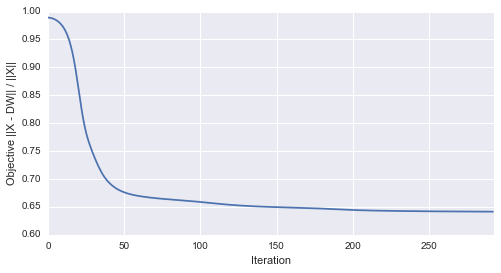

In [760]:
# Plot objective at each iteration and final learned weights.
sns.set_style('darkgrid');
plt.figure(figsize=(8, 4));

plt.plot(admm.objective);
plt.xlim(0, admm.objective.size);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

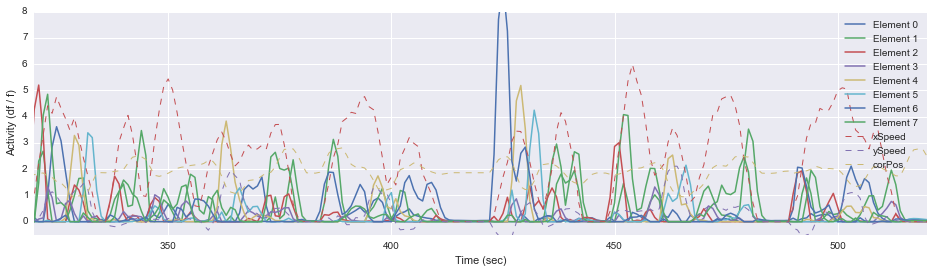

In [761]:
view = 200

def disp(start):
    
    sns.set_style('darkgrid')
    plt.figure(figsize=(16, 4));
    
    plt.plot(Wadmm.T, linewidth=1.5);
    plt.plot(reg / 8, '--', linewidth=1);    
    plt.xlabel('Time (sec)');
    plt.ylabel('Activity (df / f)');
    plt.xlim(start, start + view);
    plt.ylim(-0.5, 8);
    plt.legend(['Element ' + str(i) for i in range(k)] + reg_names);
    
widgets.interact(disp, start = (0, n_win - view, view / 10));

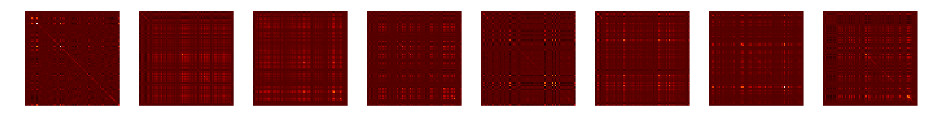

In [762]:
sns.set(rc={'axes.grid':'off', 'figure.facecolor':'white'})
plt.figure(figsize=(16, 4))

vmin = np.min(admm.dictionary)
vmax = np.max(admm.dictionary)

for i in range(k):
    plt.subplot(1, k, i + 1)   
    c = covdict.reform(admm.dictionary[:, i], n)
    plt.imshow(c, interpolation='None', cmap='gist_heat', vmin=vmin, vmax=vmax);
    plt.axis('off');

In [763]:
# Linear regression on running speed and corridor position
lr = LR(fit_intercept=True, normalize=False).fit(scale(reg, axis=0), Wadmm.T)
coef = lr.coef_
icp = lr.intercept_

In [764]:
# Correlation with running speed and corridor position (univariate model)
cor = np.corrcoef(reg.T, Wadmm)[: n_reg, n_reg :]

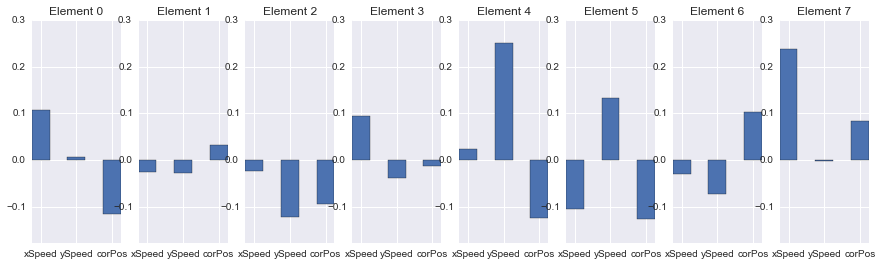

In [765]:
# Linear regression coefficients
sns.set_style('darkgrid')
fig = plt.figure(figsize=(5 * n_reg, 4));

ymin = np.min(coef) - 0.05
ymax = np.max(coef) + 0.05

for i in range(k):
    ax = fig.add_subplot(1, k, i + 1);
    plt.title('Element ' + str(i));
    plt.bar(np.arange(n_reg), coef[i, :], width=0.5);
    ax.set_xticks(np.arange(n_reg) + width / 2);
    ax.set_xticklabels(reg_names);
    plt.ylim(ymin, ymax);

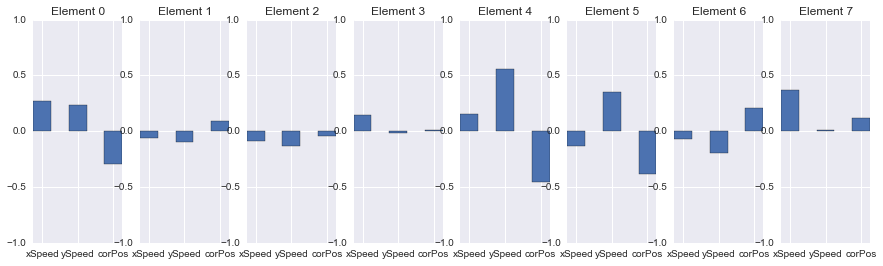

In [766]:
# Correlation coefficients
sns.set_style('darkgrid')
fig = plt.figure(figsize=(5 * n_reg, 4)); 

for i in range(k):
    ax = fig.add_subplot(1, k, i + 1);
    plt.title('Element ' + str(i));
    plt.bar(np.arange(n_reg), cor[:, i], width=0.5);
    ax.set_xticks(np.arange(n_reg) + width / 2);
    ax.set_xticklabels(reg_names);
    plt.ylim(-1, 1);

In [767]:
# "Influence" of each neuron in each dictionary element
dictionary = [covdict.reform(admm.dictionary[:, i], n) for i in range(k)]
strength = [np.sum(abs(elem), axis=0) / np.sum(abs(elem)) for elem in dictionary]
p_tune = table_active.units.pVal.values

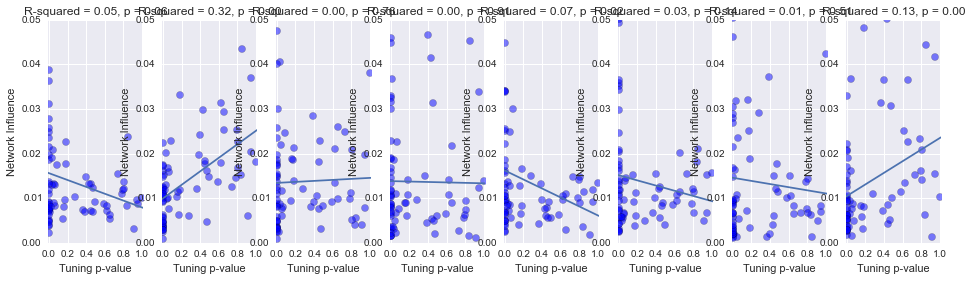

In [769]:
plt.figure(figsize=(16, 4));

xmin = -0.01
xmax = 1.01
ymin = 0
ymax = 0.05
x = [xmin, xmax]
rsqu = np.empty(k)
p_slope = np.empty(k)
 
for i in range(k):

    plt.subplot(1, k, i + 1); 
    plt.scatter(p_tune, strength[i], s=50, alpha=0.5);
    plt.xlabel('Tuning p-value');
    plt.ylabel('Network Influence');
    plt.xlim(xmin, xmax);
    plt.ylim(ymin, ymax);
    
    slope, icp, r, p_slope[i], _ = st.linregress(pval, strength[i])
    rsqu[i] = r ** 2
    y = [slope * val + icp for val in x]
    plt.plot(x, y);
    plt.title('R-squared = %0.2f, p = %0.2f' % (rsqu[i], p_slope[i]));
    


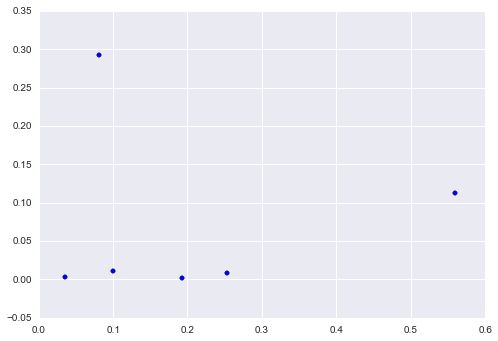

In [758]:
plt.scatter(abs(cor[-1, :]), rsqu)

In [731]:
print cor

[[ 0.24087999  0.16291943  0.00601828 -0.15302246]
 [-0.01140167  0.65576217  0.03293558 -0.21757748]
 [ 0.09512596 -0.56953588 -0.1478257   0.14393175]]
